In [1]:
!pip install tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 45kB/s 
     |████████████████████████████████| 460kB 49.8MB/s 
     |████████████████████████████████| 20.1MB 9.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 3.8MB/s 
     |████████████████████████████████| 5.6MB 23.5MB/s 
     |████████████████████████████████| 1.6MB 43.0MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [3]:
!pip install cirq

In [4]:
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


N total train:  60000
N total test:  10000
filtered N train: 12049
filtered N test: 1968


NameError: ignored

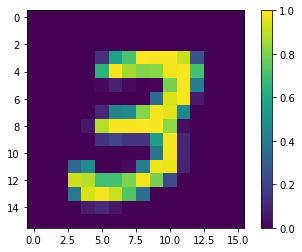

In [12]:
import collections 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("N total train: ", len(x_train))
print("N total test: ", len(x_test))

def filter_36(x,y):
  keep = (y==3)|(y==6)
  x, y = x[keep], y[keep]
  y = y == 3
  return x,y 

x_train_, y_train_ = filter_36(x_train, y_train)
x_test_, y_test_ = filter_36(x_test, y_test)

print('filtered N train:' , len(x_train_))
print('filtered N test:', len(x_test_))
size = 16
x_train_small = tf.image.resize(x_train_, (16,16)).numpy()
x_test_small = tf.image.resize(x_test_, (16,16)).numpy()

def convert_label(y):
  if y==True:
    return 1.0
  else: 
    return -1.0  #changed from -1.0

y_train_ = [convert_label(y) for y in y_train_]
y_test_ = [convert_label(y) for y in y_test_]

plt.imshow(x_train_small[0,:,:,0], vmin = 0, vmax = 1 )
plt.colorbar()

X_train = x_train_small[:300]
X_test = x_test_small[:50]
Y_train = y_train_small[:300]
Y_test = y_test_small[:50]


In [7]:
def one_qubit_unitary(bit, symbols):
  """Rotation of bloch sphere about X, Y and Z axis, that depends on values in symbols"""
  return cirq.Circuit(
      cirq.X(bit)**symbols[0],
      cirq.Y(bit)**symbols[1],
      cirq.Z(bit)**symbols[2])
  
def conv_filter_4(bits, symbols):
  circuit=cirq.Circuit()
  
  circuit += one_qubit_unitary(bits[0], symbols[0:3])
  circuit += one_qubit_unitary(bits[1], symbols[3:6])
  circuit += one_qubit_unitary(bits[2], symbols[6:9])
  circuit += one_qubit_unitary(bits[3], symbols[9:12])
  
  
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += [cirq.ZZ(first, second)**symbols[12]]
    circuit += [cirq.YY(first, second)**symbols[13]]
    circuit += [cirq.XX(first, second)**symbols[14]]
  
  circuit += one_qubit_unitary(bits[0], symbols[15:18])
  circuit += one_qubit_unitary(bits[1], symbols[18:21])
  circuit += one_qubit_unitary(bits[2], symbols[21:24])
  circuit += one_qubit_unitary(bits[3], symbols[24:])
  """
  count = 0
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += [cirq.ZZ(first, second)**symbols[count]]
    circuit += [cirq.YY(first, second)**symbols[count+1]]
    circuit += [cirq.XX(first, second)**symbols[count+2]]
    count+=3
  """
  circuit += cirq.CNOT(control = bits[0], target = bits[1])
  circuit += cirq.CNOT(control = bits[2], target = bits[3])
  circuit += cirq.CNOT(control = bits[1], target = bits[3])
  

  return circuit 



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


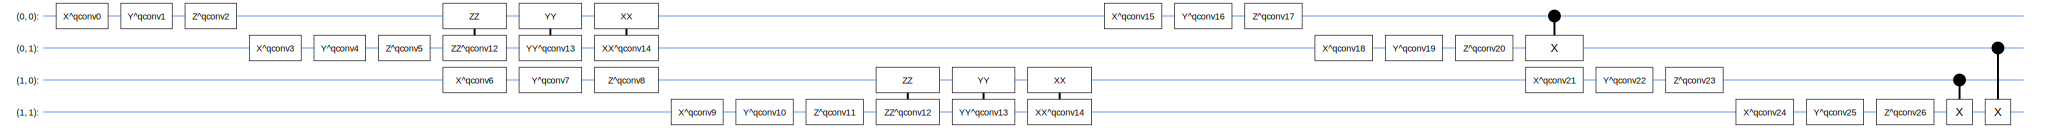

In [9]:
qubits = cirq.GridQubit.rect(2,2)
symbols = sympy.symbols('qconv0:100')
SVGCircuit(conv_filter_4(qubits, symbols))

In [25]:
conv_filter_4(qubits, symbols)

(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ───────────YY───────────XX─────────────────────────────────────────────────────────────────────────────────────X^qconv15───Y^qconv16───Z^qconv17───────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────
                                                                             │            │            │                                                                                                                                                              │
(0, 1): ────────────────────────────────────X^qconv3───Y^qconv4───Z^qconv5───ZZ^qconv12───YY^qconv13───XX^qconv14─────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───X───────────────────────────────────────────────────────────────────────────@───
                                                                                                                                                                                                                                                                                                                                                  │
(1, 0): ─────────────────────────────────────────────────────────────────────X^qconv6─────Y^qconv7─────Z^qconv8────────────────────────────────────────ZZ───────────YY───────────XX───────────────────────────────────────────────────────────────────────────────────X^qconv21───Y^qconv22───Z^qconv23───────────────────────────────────────@───┼───
                                                                                                                                                       │            │            │                                                                                                                                                            │   │
(1, 1): ────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv9───Y^qconv10───Z^qconv11───ZZ^qconv12───YY^qconv13───XX^qconv14───────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv24───Y^qconv25───Z^qconv26───X───X───

In [26]:
def conv_circuit(bits, symbols):
  circuit = cirq.Circuit()
  n = int(np.sqrt(len(bits)))
  patch = np.array(bits).reshape((n,n))
  count = 0 

  #sliding 
  for j in range(0,n,2):
    for k in range(0,n,2):
      circuit+= conv_filter_4([patch[j,k], patch[j,k+1], patch[j+1, k], patch[j+1, k+1]], symbols[count:count+27])
      count+=27 
  return circuit 


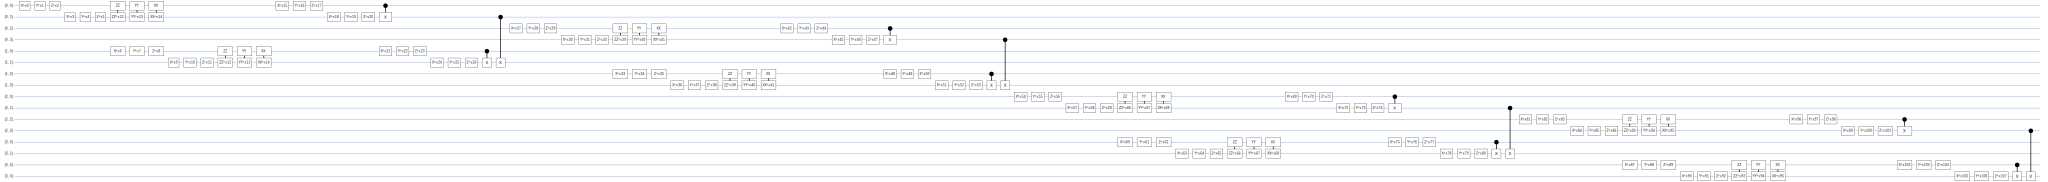

In [27]:
SVGCircuit(conv_circuit(cirq.GridQubit.rect(4,4), sympy.symbols('x0:200')))


In [28]:


def create_model(qubits):

  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:200')
  model_circuit += conv_circuit(qubits,symbols[:108])
  index = [5,7,13,15]
  model_circuit += conv_circuit([qubits[i] for i in index], symbols[108:])
  return model_circuit 

qubits16 = cirq.GridQubit.rect(4,4)
readout_operators= cirq.Z(qubits16[-1])

model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string),
                             tfq.layers.PQC(create_model(qubits16), readout_operators)])


In [24]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(4,(3,3), input_shape=(16,16,1), strides = (1,1)))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size= (2,2), strides = (1,1)))
cnn.add(tf.keras.layers.Conv2D(8,(3,3)))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size= (2,2), strides = (1,1)))
cnn.add(tf.keras.layers.Conv2D(8,(3,3)))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size= (2,2), strides = (2,2)))
cnn.add(tf.keras.layers.Conv2D(1,(1,1)))

cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 14, 14, 4)         40        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 8)         296       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 1)         

In [35]:
quantum_input = tf.keras.Input(shape=(), dtype = tf.dtypes.string)
cnn.output



<tf.Tensor 'conv2d_28/BiasAdd:0' shape=(None, 4, 4, 1) dtype=float32>

In [36]:
#encode images to quantum states

def encode_circuit(values):
  #im4 = values[1:5,1:5]
  #phi = np.ndarray.flatten(im4)
  phi = tf.reshape(values, [4*4])
  encode_circuit = cirq.Circuit()
  qubits = cirq.GridQubit.rect(4,4)

  for i in range(16):
    encode_circuit.append(cirq.ry(np.pi*phi[i])(qubits[i]))
  return encode_circuit 


In [ ]:
x_train_16 = tfq.convert_to_tensor([encode_circuit(x) for x in X_train])
x_test_16 = tfq.convert_to_tensor([encode_circuit(x) for x in X_test])

In [ ]:
@tf.function 

def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)>0.0
  y_pred = tf.squeeze(y_pred)>0.0
  result = tf.cast(y_true == y_pred, tf.float32)
  return tf.reduce_mean(result)



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [ ]:
history = model.fit(x=x_train_16,
                         y=np.asarray(Y_train),
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(x_test_16, np.asarray(Y_test)))

Epoch 1/25
19/19 [==============================] - 22s 1s/step - loss: 0.9907 - hinge_accuracy: 0.6985 - val_loss: 0.9871 - val_hinge_accuracy: 0.6406
Epoch 2/25
19/19 [==============================] - 23s 1s/step - loss: 0.9682 - hinge_accuracy: 0.7741 - val_loss: 0.9663 - val_hinge_accuracy: 0.6562
Epoch 3/25
19/19 [==============================] - 23s 1s/step - loss: 0.9226 - hinge_accuracy: 0.8246 - val_loss: 0.9268 - val_hinge_accuracy: 0.7031
Epoch 4/25
19/19 [==============================] - 23s 1s/step - loss: 0.8574 - hinge_accuracy: 0.8575 - val_loss: 0.8731 - val_hinge_accuracy: 0.7031
Epoch 5/25
19/19 [==============================] - 22s 1s/step - loss: 0.7832 - hinge_accuracy: 0.8629 - val_loss: 0.8243 - val_hinge_accuracy: 0.6875
Epoch 6/25
19/19 [==============================] - 22s 1s/step - loss: 0.7154 - hinge_accuracy: 0.8509 - val_loss: 0.7853 - val_hinge_accuracy: 0.6875
Epoch 7/25
19/19 [==============================] - 25s 1s/step - loss: 0.6532 - hinge_a

Serialize mutiqubit added to tensorflow quantum new version -- check to form multi-qubit gates 

In [ ]:
preds=model.predict_classes(x_test_16)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


-1.0
Prediction: [1]


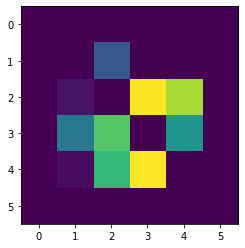

1.0
Prediction: [0]


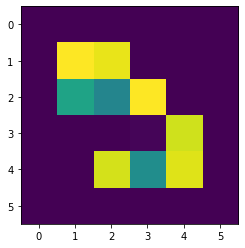

-1.0
Prediction: [0]


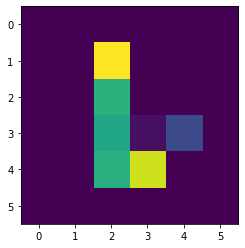

-1.0
Prediction: [1]


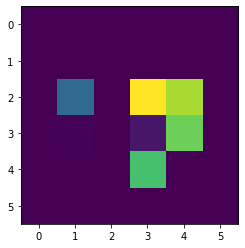

1.0
Prediction: [0]


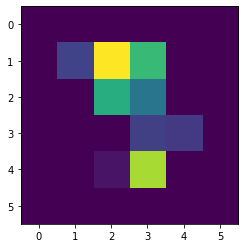

1.0
Prediction: [0]


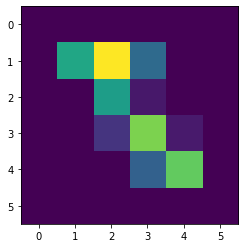

1.0
Prediction: [0]


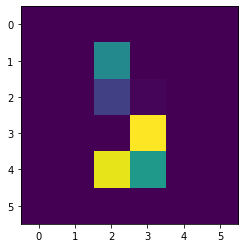

-1.0
Prediction: [0]


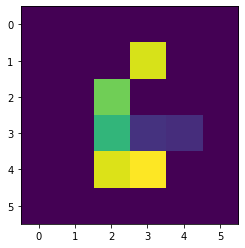

1.0
Prediction: [0]


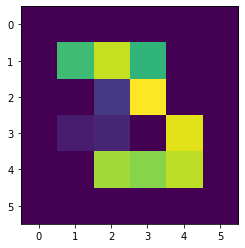

-1.0
Prediction: [0]


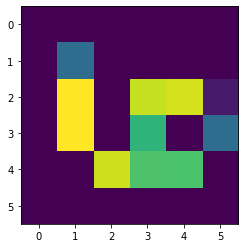

1.0
Prediction: [0]


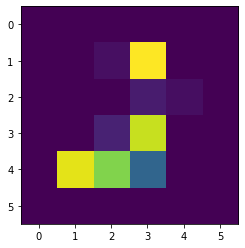

-1.0
Prediction: [1]


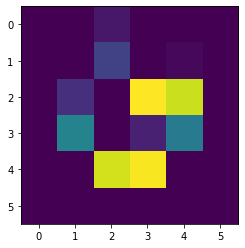

1.0
Prediction: [1]


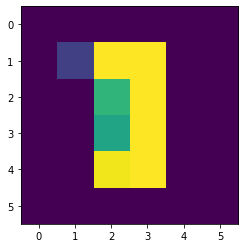

1.0
Prediction: [0]


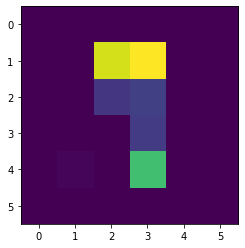

-1.0
Prediction: [0]


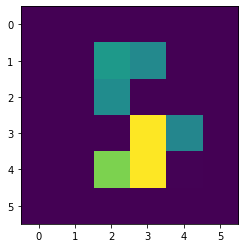

1.0
Prediction: [0]


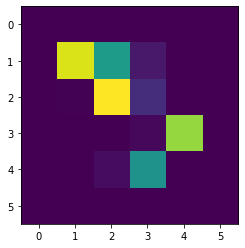

-1.0
Prediction: [0]


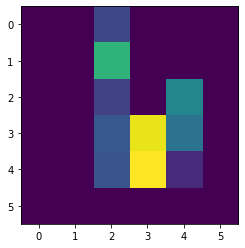

1.0
Prediction: [1]


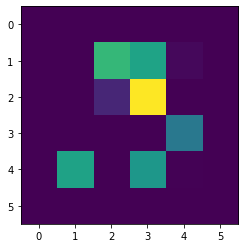

-1.0
Prediction: [0]


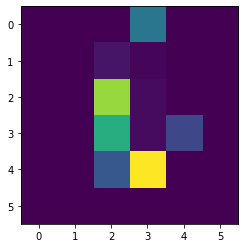

1.0
Prediction: [1]


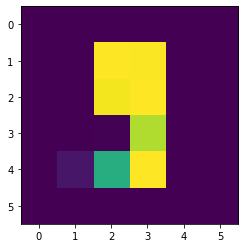

-1.0
Prediction: [0]


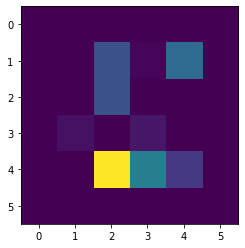

-1.0
Prediction: [0]


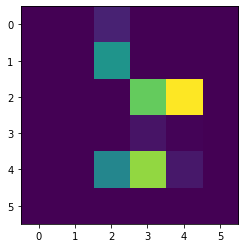

1.0
Prediction: [0]


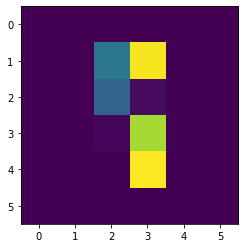

-1.0
Prediction: [0]


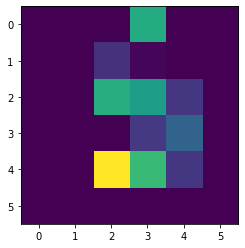

-1.0
Prediction: [0]


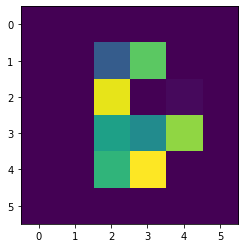

-1.0
Prediction: [0]


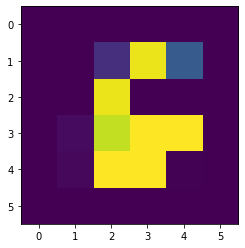

-1.0
Prediction: [0]


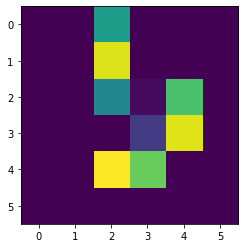

-1.0
Prediction: [0]


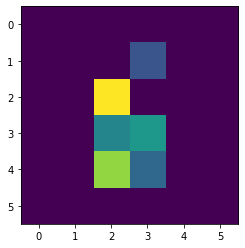

1.0
Prediction: [1]


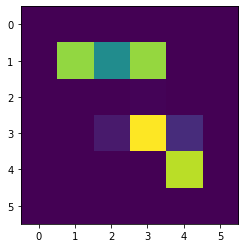

-1.0
Prediction: [0]


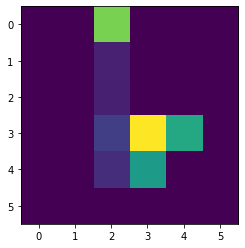

1.0
Prediction: [0]


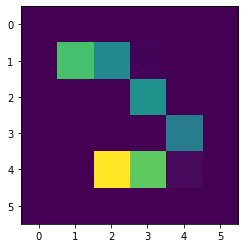

-1.0
Prediction: [0]


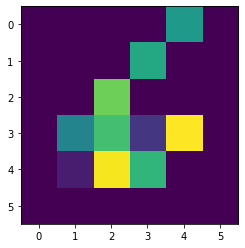

-1.0
Prediction: [0]


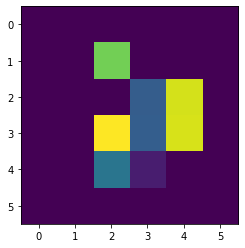

1.0
Prediction: [1]


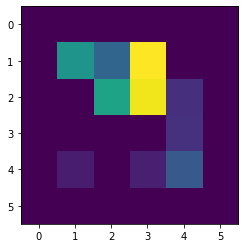

1.0
Prediction: [0]


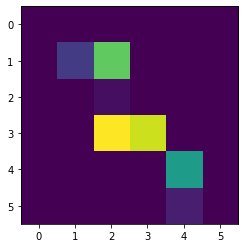

-1.0
Prediction: [0]


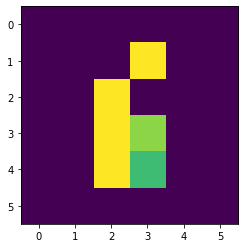

1.0
Prediction: [1]


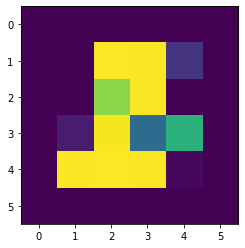

-1.0
Prediction: [0]


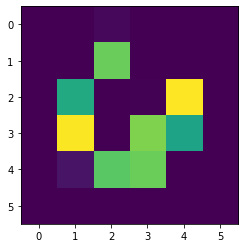

1.0
Prediction: [0]


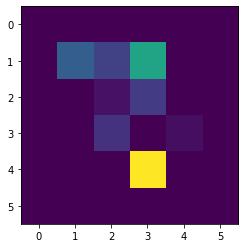

1.0
Prediction: [1]


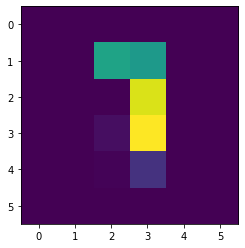

1.0
Prediction: [1]


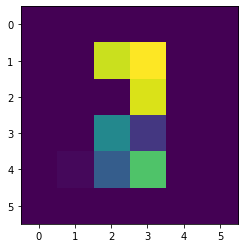

-1.0
Prediction: [0]


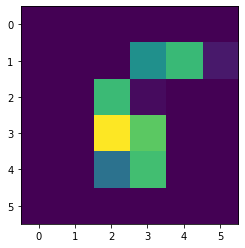

1.0
Prediction: [1]


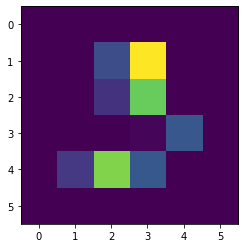

1.0
Prediction: [0]


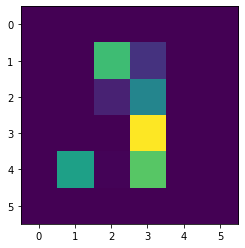

1.0
Prediction: [0]


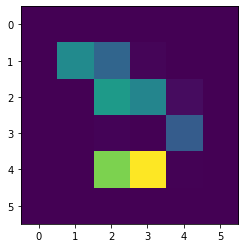

-1.0
Prediction: [0]


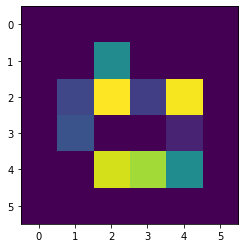

1.0
Prediction: [1]


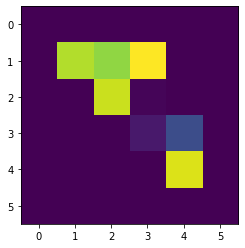

-1.0
Prediction: [0]


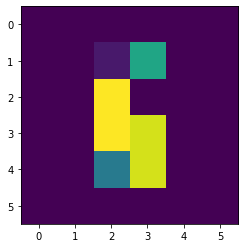

1.0
Prediction: [0]


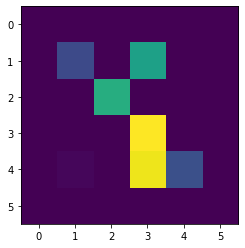

1.0
Prediction: [1]


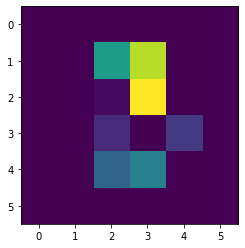

In [ ]:
for i in range(len(X_test)):
  print(Y_test[i])
  print('Prediction:', preds[i])
  plt.imshow(X_test[i,:,:,0])
  plt.show()

In [ ]:
preds

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 135       
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds2=model.predict(x_test_16)

In [ ]:
def convert_preds(y):
  if y>0.0:
    return 1.0
  else: 
    return 0.0  #changed from -1.0



In [ ]:
preds_out = [convert_preds(y) for y in preds2]

In [ ]:
Y_test_ = [convert_preds(y) for y in Y_test]

In [ ]:
preds_out

[1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0]

In [ ]:
Y_test

[-1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0]

In [ ]:
tf.math.confusion_matrix(Y_test_, preds_out)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[19,  5],
       [13, 13]], dtype=int32)>

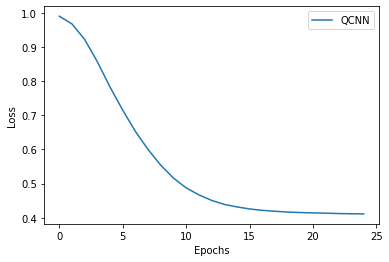

In [ ]:
plt.plot(history.history['loss'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.show()

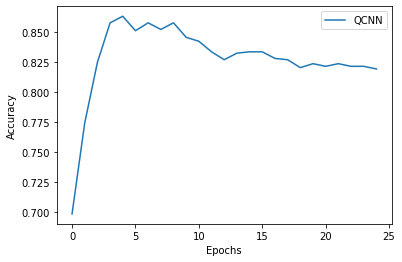

In [ ]:
plt.plot(history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

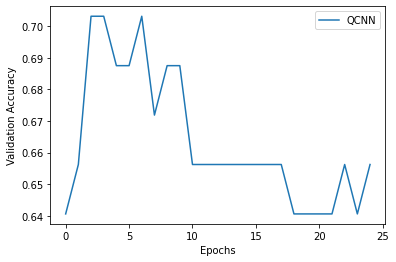

In [ ]:
plt.plot(history.history['val_hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/Courses & Online Courses/COMP 551/Project/model1')

In [ ]:

X_test_2 = x_test_small [50:100]

Y_test_2 = y_test[50:100]

#x_train_16 = tfq.convert_to_tensor([encode_circuit(x) for x in X_train])
x_test_2 = tfq.convert_to_tensor([encode_circuit(x) for x in X_test_2])

